In [2]:
import numpy as np 
import pandas as pd
import os 

## Data 

In [3]:
train_df = pd.read_csv('data/train.csv')

In [4]:
train_df.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [42]:
train_df['label_group'].unique()

array([ 666, 7572, 6172, ..., 3388, 1968,  132], dtype=int16)

In [4]:
train_df.isna().sum(axis=0)

posting_id     0
image          0
image_phash    0
title          0
label_group    0
dtype: int64

Number of products

In [5]:
train_df['label_group'].nunique()

11014

Number of offers per product (offer = (image + text description))

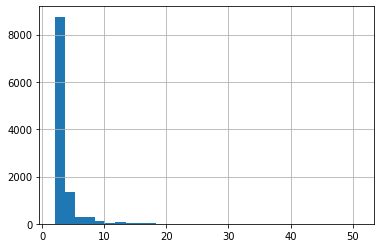

In [6]:
train_df.groupby('label_group').count()['image'].hist(bins=30)


In [7]:
train_df.groupby('label_group').count()['image'].value_counts()[:20]

2     6979
3     1779
4      862
5      468
6      282
7      154
8      118
9       91
10      48
12      39
11      38
13      28
14      19
15      19
16      13
17       9
51       7
21       6
20       6
22       6
Name: image, dtype: int64

Most of the products have only a few offers (2-6)

## Dataset and Processing

The images are contained on the folder train_images

In [22]:
images_path = 'data/train_images/'
image_ids = [s.split('.')[0] for s in os.listdir(images_path)]
image_ids[:10]

['bf147de7e932b44b57d961854f2da122',
 '5679405e23c704bb4296505fdc1bdc8b',
 'ca25d1085f7d90278d23299a8419fbe7',
 '6ed5195d22d560a037a298680ab948e3',
 '1e24285a491d9b5673d1d9c0e13650ac',
 'c6824fbe5f7974a57fa2de0aea664927',
 'a39063acff5167d307c7bf1a6022ff70',
 '7808dc5b8f1bce90d66cedf9dfab12ab',
 '45de21867494d0570d2962775331550e',
 '7741376b86dad8778948202889312155']

In [21]:
import os
import torchvision
import torch
import random
import functools
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
from transformers import AutoTokenizer
from functools import partial

We use torchvision to load and process images. Each image is of 1024x1024 pixels which is too much so we resize it to 224x224 which is the imagenet standard. The embedding of the images will be done by the model so we just need to return the raw images. As for the text, right now we will simply use a TfidfVectorizer to embed titles, we will afterwards use pretrained models.

In [26]:
class TripletDataset(Dataset) :
    def __init__(self, images_path, df_path, tfs_image=torchvision.transforms.Resize((224, 224)), text_tokenizer=None) :
        super(TripletDataset, self).__init__()
        
        self.images_path = images_path
        
        # Reshaping only
        # data augm + norm is done on batches for faster computation 
        self.tfs_image = tfs_image
        
        self.df = pd.read_csv(df_path)
        self.df['label_group'] = self.df['label_group'].astype('category').cat.codes
        self.df['index'] = range(self.df.shape[0])
        self.labels = self.df['label_group'].unique()
        self.label_to_index_list = self.df.groupby('label_group')['index'].apply(list)
        
    def __getitem__(self, index) :
        index_meta = self.df.iloc[index]
        
        anchor_image, anchor_text = self._get_item(index)
        
        label = index_meta['label_group']
        
        # positive sample
        pos_index = random.choice(self.label_to_index_list[label])
        # we don't want the positive sample being the same as the anchor
        while pos_index == index :
            pos_index = random.choice(self.label_to_index_list[label])
        pos_image, pos_text = self._get_item(pos_index)
        
        #negative sample
        neg_label = random.choice(self.labels)
        # Negative sample has to be different label from anchor 
        while neg_label == index :
            neg_label = random.choice(self.labels)
        neg_index = random.choice(self.label_to_index_list[neg_label])
        neg_image, neg_text = self._get_item(neg_index)
        
        return anchor_image, anchor_text, pos_image, pos_text, neg_image, neg_text
        
    def _get_item(self, index) :
        image = self.tfs_image(torchvision.io.read_image(os.path.join(self.images_path, self.df.iloc[index]['image'])))
        text = self.df.iloc[index]['title']
        return image, text
    
    def __len__(self) :
        return self.df.shape[0]

In [62]:
def collate_fn(tokenizer, samples) :
    batch_size = len(samples)
    anchor_images, anchor_texts, pos_images, pos_texts, neg_images, neg_texts = zip(*samples)
    anchor_images = torch.stack(anchor_images)
    pos_images = torch.stack(pos_images)
    neg_images = torch.stack(neg_images)
    anchor_texts = tokenizer(list(anchor_texts), padding=True, truncation=True, return_tensors="pt")
    pos_texts = tokenizer(list(pos_texts), padding=True, truncation=True, return_tensors="pt")
    neg_texts = tokenizer(list(neg_texts), padding=True, truncation=True, return_tensors="pt")
    return anchor_images, anchor_texts, pos_images, pos_texts, neg_images, neg_texts

In [63]:
def create_dl(images_path, df_paths, pretrianed_tokenizer='distilbert-base-uncased', batch_size=64) :
    dataset = TripletDataset(images_path, df_paths)
    tokenizer = AutoTokenizer.from_pretrained(pretrianed_tokenizer)
    dl = DataLoader(dataset, batch_size=batch_size, collate_fn=partial(collate_fn, tokenizer))
    return dl

## Model

In [95]:
import torch.nn as nn
import timm
from transformers import DistilBertModel

In [113]:
class EmbedorNN(nn.Module) :
    def __init__(self, pretrained_image_embedor='resnet18', pretrained_text_embedor='distilbert-base-uncased',
                output_dim=124, ) :
        super(EmbedorNN, self).__init__()
        self.image_embedor = timm.create_model(pretrained_image_embedor, pretrained=True)
        self.text_embedor = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.head = nn.Linear(512+39, output_dim)
    
    def forward(self, x) :
        images, texts = x
        out_images = self.image_embedor.forward_features(images).mean(-1).mean(-1)
        out_text = self.text_embedor(texts['input_ids'], attention_mask=texts['attention_mask']).get('last_hidden_state').mean(-1)
        out = torch.cat([out_images, out_text], dim=-1)
        return self.head(out)
        

## Training loop